# Worksheet 6

## Imports and previous stuff

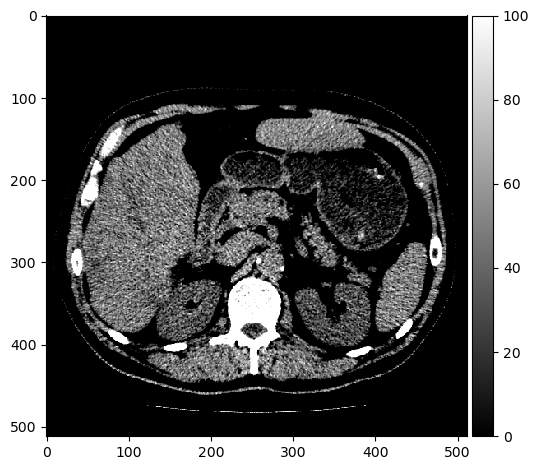

In [12]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()


ct = dicom.read_file('C:/Users/Admin/Documents/HCAI/IMAGE_ANALYSIS/exercises/ex6-PixelClassificationAndObjectSegmentation/data/Training.dcm')
img = ct.pixel_array
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

## Preliminar Analysis of one CT scan
- mask of the CT image with expert annotations
- fit a gaussian distribution to some values of the CT image
- plot multiple gaussians in the same figure

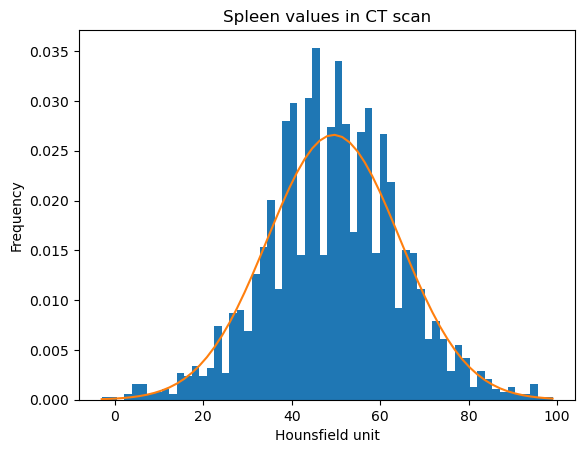

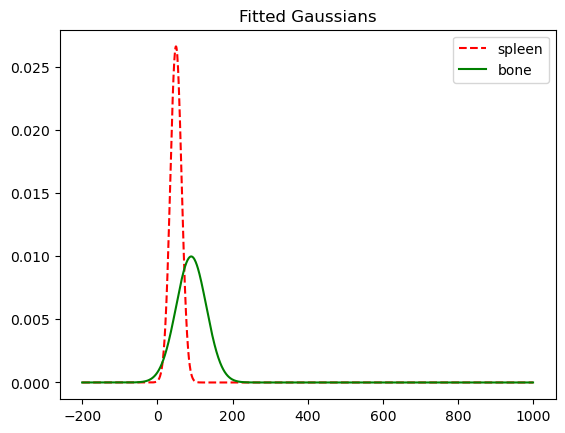

In [21]:
#mask of the CT image
spleen_roi = io.imread('C:/Users/Admin/Documents/HCAI/IMAGE_ANALYSIS/exercises/ex6-PixelClassificationAndObjectSegmentation/data/SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0 #white values
spleen_values = img[spleen_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )

#fit a gaussian
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

#plor multiple gaussians in the same figure
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
mu_bone = 90
std_bone = 40
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()


## Minimum Distance pixel classification
In the minimum distance classifier the pixel value class ranges are defined using the average values of the training values. If you have two classes, the threshold between them is defined as the mid-point between the two class value averages.

1. compute mean of the values of each class
2. set the thresholds (background threshold is set manually)
3. compute the images results
4. display the images combined

In [ ]:
#compute the mean of the values of each class
soft_tissue_mean = np.mean(vals_soft_tissue)
bone_mean = np.mean(values[0])
fat_mean = np.mean(values[1])

print(f'Soft tissue mean: {soft_tissue_mean} - Bone mean: {bone_mean} - Fat mean: {fat_mean}')

#compute the thresholds
t_background = -200 #decided by me
t_fat_soft = (soft_tissue_mean + fat_mean)/2
t_bone_soft = (soft_tissue_mean + bone_mean)/2

#compute the images
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_bone_soft)
bone_img = (img > t_bone_soft) & (img <= 1000)

#display the images
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')


## Parametric pixel classification
In the parametric classifier, the standard deviation of the training pixel values is also used when determinin the class ranges.

1. inspect the fitted gaussian and find the intersection between the curves
2. set the thresholds using the values found in the previous point (background threshold is set manually)
3. compute the images results
4. display the images combined

In [ ]:
#inspect the fitted gaussians and find the intersections
# Automatic intersection Fat - Soft
for test_value in np.linspace(mu_fat, mu_soft, 1000):
    if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_fat, std_fat):
        thres_fat_soft = test_value
        print(f"Fat - Soft threshold: {thres_fat_soft}")
        break

# Automatic intersection Soft - Bone
for test_value in np.linspace(mu_soft, mu_bone, 1000):
    if norm.pdf(test_value, mu_bone, std_bone) > norm.pdf(test_value, mu_soft, std_soft):
        thres_soft_bone = test_value
        print(f"Soft - Bone threshold: {thres_soft_bone}")
        break

#compute the images
fat_img = (img > t_background) & (img <= thres_fat_soft)
soft_img = (img > thres_fat_soft) & (img <= thres_soft_bone)
bone_img = (img > thres_soft_bone) & (img <= 1000)

#display the images
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')


## Spleen Finder 

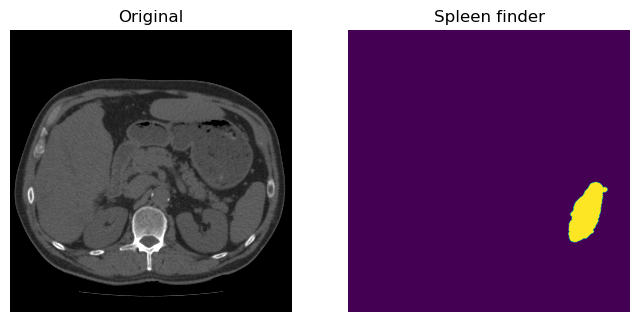

In [23]:
def spleen_finder(img):
    t_1, t_2 = 20, 80
    spleen_estimate = (img > t_1) & (img < t_2)

    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)
    footprint = disk(4)
    opened = binary_opening(closed, footprint)

    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)

    min_area = 2000
    max_area = 10000
    min_perimeter = 100
    max_perimeter = 350

    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the areas that do not fit our criteria
        crit1 = region.area > max_area or region.area < min_area
        crit2 = region.perimeter > max_perimeter or region.perimeter < min_perimeter
        if crit1 or crit2:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    
    # Create binary image from the filtered label image
    i_area_perimeter = label_img_filter > 0
    
    return i_area_perimeter

spleen_estimate = spleen_finder(img)
show_comparison(img, spleen_estimate, 'Spleen finder')

## DICE score
The DICE score (also called the DICE coefficient or the DICE distance) is a standard method of comparing one segmentation with another segmentation.
If segmentation one is called X and the second segmentation called Y. The DICE score is computed as

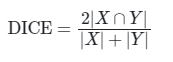


In [26]:
ground_truth_img = io.imread('C:/Users/Admin/Documents/HCAI/IMAGE_ANALYSIS/exercises/ex6-PixelClassificationAndObjectSegmentation/data/Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen_estimate.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.9565613955079239
